VGGNET16 With Keras and Implants

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
# import os
# os.kill(os.getpid(), 9)

In [ ]:
#Run this twice to install correct version of keras

!pip install -U keras==2.1.5

  Using cached Keras-2.1.5-py2.py3-none-any.whl (334 kB)
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0


In [ ]:
import tensorflow
import skimage
print(tensorflow.__version__,  skimage.__version__)
import keras
keras.__version__

1.15.2 0.18.3


Using TensorFlow backend.


'2.1.5'

In [ ]:
import os
import sys
import datetime
import glob as glob
import numpy as np
import cv2
import keras
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Input
from keras.models import Model
from keras.layers import GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import tensorflow
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Mapping to your location in google drive

import os
os.chdir("/content/drive/MyDrive/1_ImplantProject/dataset_vgg")
!pwd

/content/drive/MyDrive/1_ImplantProject/dataset_vgg


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'reflect'
    # fill_mode = 'nearest'
)



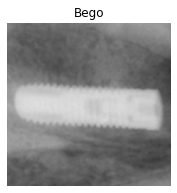

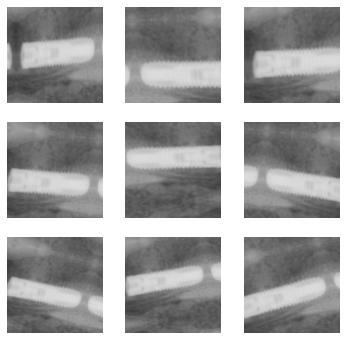

In [ ]:
imgPath1 = './train/bego/bego (1).jpg'
img = load_img(imgPath1)
plt.figure(figsize = (3,3))
plt.imshow(img)
plt.axis('off')
plt.title('Bego')
plt.show()

x = img_to_array(img)
x2 = x.reshape((1,) + x.shape)

i = 0
fig = plt.figure(figsize = (6,6))
plt.title('Pre-processed')
for batch in datagen.flow(x2, batch_size = 1):
    i += 1
    if i > 9:
        break
    temp = batch.reshape(x.shape)
    plt.subplot(3, 3, i)
    plt.imshow(temp.astype('uint8'))
    plt.axis('off')
plt.show()


In [ ]:
# default settings
batch_size = 10
nb_epochs = 200
height, width = (224,224)

train_dir = './train'
validate_dir = './val'


nb_classes = len(glob.glob(train_dir + '/*'))
print(nb_classes)

3


In [ ]:
# get number of images in training directory
nb_train_samples = 0
for r, dirs, files in os.walk(train_dir):
    for dr in dirs:
        nb_train_samples += len(glob.glob(os.path.join(r, dr + "/*")))
print('training set', nb_train_samples)

# get number of images in validation directory
nb_validate_samples = 0
for r, dirs, files in os.walk(validate_dir):
    for dr in dirs:
        nb_validate_samples += len(glob.glob(os.path.join(r, dr + "/*")))
print('validation set', nb_validate_samples)

training set 1650
validation set 565


In [ ]:
# data pre-processing for training
train_datagen =  ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = 'reflect',
    horizontal_flip = True)

# data pre-processing for validation
validate_datagen =  ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = 'reflect',
    horizontal_flip = True)



train_dataset = train_datagen.flow_from_directory(
  train_dir, 
  target_size = (width, height), 
  batch_size = batch_size
)

val_dataset = validate_datagen.flow_from_directory(
  validate_dir, 
  target_size = (width, height), 
  batch_size = batch_size
)

histories = []


Found 1650 images belonging to 3 classes.
Found 565 images belonging to 3 classes.


In [ ]:
# Utility function for plotting of the model results
def visualize_results(history):
    # Plot the accuracy and loss curves
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()


In [ ]:
from keras.utils import data_utils
def modifiedVGG16(classes=3):
  img_rows, img_cols = 224, 224   # by default size is 224,224
  img_channels = 3

  img_dim = (img_rows, img_cols, img_channels)
  # Building the CNN model
  model = Sequential()

  img_input = Input(shape=img_dim)

  # Block 1
  x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')( img_input)
  x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
  x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

  # Block 2
  x = Conv2D( 128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
  x = Conv2D( 128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
  x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

  # Block 3
  x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
  x = Conv2D( 256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
  x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
  x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

  # Block 4
  x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
  x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
  x = Conv2D( 512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
  x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

  # Block 5
  x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
  x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
  x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
  x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

  WEIGHTS_PATH_NO_TOP = ('https://storage.googleapis.com/tensorflow/'
                       'keras-applications/vgg16/'
                       'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')

  weights_path = data_utils.get_file(
          'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
          WEIGHTS_PATH_NO_TOP,
          cache_subdir='models',
          file_hash='64373286793e3c8b2b4e3219cbf3544b')


  model = Model(inputs = img_input, outputs = x, name='ModifiedVGG16')
  
  model.load_weights(weights_path)
  return model

In [ ]:
import warnings
warnings.filterwarnings("ignore")

base_model = modifiedVGG16(classes=3)
base_model.summary()





58892288/58889256 [==============================] - 0s 0us/step






_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
b

#Run Original Model #1
- Flatten
- 3 Denses (4096, 4096, 3) 
- Optimizer adam(0.001)

In [ ]:
# freeze all layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten(name='flatten')(x)
x = Dense(4096, activation='relu')(x)
x = Dense(4096, activation='relu')(x)
predictions = Dense(nb_classes, activation = 'softmax')(x)
mod_model1 = Model(inputs= base_model.input, outputs= predictions)

opt = Adam(lr=0.001)
mod_model1.compile(optimizer = opt,
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

#Print the model summary
print(mod_model1.summary())

# fit the model, log the results and the training time
now = datetime.datetime.now
t = now()
transfer_learning_history1 = mod_model1.fit_generator(
    train_dataset,
    nb_epoch = nb_epochs,
    samples_per_epoch = nb_train_samples,
    validation_data = val_dataset,
    nb_val_samples = nb_validate_samples,
    class_weight='auto')
print('Training time: %s' % (now() - t))

#append result to history list
histories.append(transfer_learning_history1)

# evaluate the performance the new model and report the results
score = mod_model1.evaluate_generator(val_dataset, nb_validate_samples/batch_size)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])
# save transfer learning model for offline prediction purposes
# current date and time
now = datetime.datetime.now()
timestamp = datetime.datetime.timestamp(now)
mod_model1.save('implant_modified_vgg16_model1_tl.' + str(timestamp) + '.h5')



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
________

# Notes for the results of model1

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
_________________________________________________________________
block3_conv2 (Conv2D)        (None, 56, 56, 256)       590080    
_________________________________________________________________
block3_conv3 (Conv2D)        (None, 56, 56, 256)       590080    
_________________________________________________________________
block3_pool (MaxPooling2D)   (None, 28, 28, 256)       0         
_________________________________________________________________
block4_conv1 (Conv2D)        (None, 28, 28, 512)       1180160   
_________________________________________________________________
block4_conv2 (Conv2D)        (None, 28, 28, 512)       2359808   
_________________________________________________________________
block4_conv3 (Conv2D)        (None, 28, 28, 512)       2359808   
_________________________________________________________________
block4_pool (MaxPooling2D)   (None, 14, 14, 512)       0         
_________________________________________________________________
block5_conv1 (Conv2D)        (None, 14, 14, 512)       2359808   
_________________________________________________________________
block5_conv2 (Conv2D)        (None, 14, 14, 512)       2359808   
_________________________________________________________________
block5_conv3 (Conv2D)        (None, 14, 14, 512)       2359808   
_________________________________________________________________
block5_pool (MaxPooling2D)   (None, 7, 7, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              102764544 
_________________________________________________________________
dense_2 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 12291     
=================================================================
Total params: 134,272,835
Trainable params: 119,558,147
Non-trainable params: 14,714,688
## Add notes below
Epoch 200/200
165/165 [==============================] - 104s 632ms/step - loss: 10.7454 - acc: 0.3333 - val_loss: 10.8211 - val_acc: 0.3286
Training time: 6:02:34.324783
Test Score: 10.926071867478631
Test Accuracy: 0.3221239000558853

## My notes:
- The accuracy is not increased during traing with 100 epochs, it seems the number of training params are too big cause the model underfitting the features

# Modified VGG16 #2 
- From Flatten to GlobalAveragePooling
- Keep 3 Denses (4096, 4096, 3)
- Adam (0.001)


In [ ]:
# freeze all layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)  #Change from Flatten to GAP
x = Dense(4096, activation='relu')(x)
x = Dense(4096, activation='relu')(x)
predictions = Dense(nb_classes, activation = 'softmax')(x)
mod_model2 = Model(inputs= base_model.input, outputs= predictions)

opt = Adam(lr=0.001)
mod_model2.compile(optimizer = opt,
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

#Print the model summary
print(mod_model2.summary())

# fit the model, log the results and the training time
now = datetime.datetime.now
t = now()
transfer_learning_history2 = mod_model2.fit_generator(
    train_dataset,
    nb_epoch = nb_epochs,
    samples_per_epoch = nb_train_samples,
    validation_data = val_dataset,
    nb_val_samples = nb_validate_samples,
    class_weight='auto')
print('Training time: %s' % (now() - t))

#append result to history list
histories.append(transfer_learning_history2)

# evaluate the performance the new model and report the results
score = mod_model2.evaluate_generator(val_dataset, nb_validate_samples/batch_size)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])
# save transfer learning model for offline prediction purposes
# current date and time
now = datetime.datetime.now()
timestamp = datetime.datetime.timestamp(now)
mod_model2.save('implant_modified_vgg16_model2_tl.' + str(timestamp) + '.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

# Notes for the results of model2
## Add notes below
Epoch 200/200
165/165 [==============================] - 104s 632ms/step - loss: 0.1935 - acc: 0.9182 - val_loss: 0.7930 - val_acc: 0.7301
Training time: 5:48:34.095787
Test Score: 0.749877745730687
Test Accuracy: 0.7469026551837414


# Modified VGG16 #3
- From Flatten to GlobalAveragePooling
- Change from 3 Denses (4096, 4096, 3) to two Denses (4096, 3)
- Adam (0.001)


In [ ]:
# freeze all layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)  #Change from Flatten to GAP
# x = Dense(4096, activation='relu')(x)  #Just keep one Dense 4096
x = Dense(4096, activation='relu')(x)
predictions = Dense(nb_classes, activation = 'softmax')(x)
mod_model3 = Model(inputs= base_model.input, outputs= predictions)

opt = Adam(lr=0.001)
mod_model3.compile(optimizer = opt,
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

#Print the model summary
print(mod_model3.summary())

# fit the model, log the results and the training time
now = datetime.datetime.now
t = now()
transfer_learning_history3 = mod_model3.fit_generator(
    train_dataset,
    nb_epoch = nb_epochs,
    samples_per_epoch = nb_train_samples,
    validation_data = val_dataset,
    nb_val_samples = nb_validate_samples,
    class_weight='auto')
print('Training time: %s' % (now() - t))

#append result to history list
histories.append(transfer_learning_history3)


# evaluate the performance the new model and report the results
score = mod_model3.evaluate_generator(val_dataset, nb_validate_samples/batch_size)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])
# save transfer learning model for offline prediction purposes
# current date and time
now = datetime.datetime.now()
timestamp = datetime.datetime.timestamp(now)
mod_model3.save('implant_modified_vgg16_model3_tl.' + str(timestamp) + '.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

# Notes for the results of model3
## Add notes below
Epoch 192/200
165/165 [==============================] - 105s 635ms/step - loss: 0.1681 - acc: 0.9370 - val_loss: 0.4837 - val_acc: 0.8248
Epoch 193/200
165/165 [==============================] - 105s 638ms/step - loss: 0.1731 - acc: 0.9303 - val_loss: 0.4254 - val_acc: 0.8441
Epoch 194/200
165/165 [==============================] - 104s 628ms/step - loss: 0.1602 - acc: 0.9418 - val_loss: 0.6466 - val_acc: 0.7737
Epoch 195/200
165/165 [==============================] - 104s 629ms/step - loss: 0.1745 - acc: 0.9352 - val_loss: 0.4998 - val_acc: 0.8096
Epoch 196/200
165/165 [==============================] - 104s 633ms/step - loss: 0.2052 - acc: 0.9188 - val_loss: 0.3887 - val_acc: 0.8459
Epoch 197/200
165/165 [==============================] - 104s 630ms/step - loss: 0.1893 - acc: 0.9182 - val_loss: 0.4849 - val_acc: 0.8345
Epoch 198/200
165/165 [==============================] - 104s 630ms/step - loss: 0.1730 - acc: 0.9321 - val_loss: 0.6652 - val_acc: 0.7802
Epoch 199/200
165/165 [==============================] - 105s 635ms/step - loss: 0.1952 - acc: 0.9230 - val_loss: 0.5269 - val_acc: 0.8136
Epoch 200/200
165/165 [==============================] - 104s 632ms/step - loss: 0.1910 - acc: 0.9352 - val_loss: 0.6508 - val_acc: 0.7784
Training time: 5:46:45.080457
Test Score: 0.6634591279831608
Test Accuracy: 0.7769911489655487

# Modified VGG16 #4
- From Flatten to GlobalAveragePooling
- Change from two Denses (4096, 3) to two denses (1024, 3)
- Adam (0.001)


In [ ]:
nb_epochs = 200

# freeze all layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)  #Change from Flatten to GAP
x = Dense(1024, activation='relu')(x) #Change from 4096 to 1024
predictions = Dense(nb_classes, activation = 'softmax')(x)
mod_model4 = Model(inputs= base_model.input, outputs= predictions)

opt = Adam(lr=0.001)
mod_model4.compile(optimizer = opt,
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

#Print the model summary
print(mod_model4.summary())

# fit the model, log the results and the training time
now = datetime.datetime.now
t = now()
transfer_learning_history4 = mod_model4.fit_generator(
    train_dataset,
    nb_epoch = nb_epochs,
    samples_per_epoch = nb_train_samples,
    validation_data = val_dataset,
    nb_val_samples = nb_validate_samples,
    class_weight='auto')
print('Training time: %s' % (now() - t))

#append result to history list

histories.append(transfer_learning_history4)

now = datetime.datetime.now()
timestamp = datetime.datetime.timestamp(now)
mod_model4.save('implant_modified_vgg16_model4_tl.' + str(timestamp) + '.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [ ]:
visualize_results(transfer_learning_history4)
# evaluate the performance the new model and report the results
score4 = mod_model4.evaluate_generator(val_dataset, nb_validate_samples/batch_size)
print("Test Score:", score4[0])
print("Test Accuracy:", score4[1])

# Notes for the results of model4
## Add notes below
Epoch 194/200
165/165 [==============================] - 104s 628ms/step - loss: 0.1677 - acc: 0.9382 - val_loss: 0.3331 - val_acc: 0.8750

Epoch 195/200
165/165 [==============================] - 104s 628ms/step - loss: 0.2175 - acc: 0.9133 - val_loss: 0.3630 - val_acc: 0.8629

Epoch 196/200
165/165 [==============================] - 105s 637ms/step - loss: 0.1931 - acc: 0.9248 - val_loss: 0.3873 - val_acc: 0.8600

Training time: 5:46:56.148313

# Modified VGG16 #5
- From Flatten to GlobalAveragePooling
- Change from two Denses (4096, 3) to two denses (1024, 3)
- Adam (0.001)
- Change RELU to ELU

In [ ]:
nb_epochs = 200

# freeze all layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)  #Change from Flatten to GAP
x = Dense(1024, activation='elu')(x) #"Change from relu to elu"
predictions = Dense(nb_classes, activation = 'softmax')(x)
mod_model5 = Model(inputs= base_model.input, outputs= predictions)

opt = Adam(lr=0.001)
mod_model5.compile(optimizer = opt,
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

#Print the model summary
print(mod_model5.summary())

# fit the model, log the results and the training time
now = datetime.datetime.now
t = now()
transfer_learning_history5 = mod_model5.fit_generator(
    train_dataset,
    nb_epoch = nb_epochs,
    samples_per_epoch = nb_train_samples,
    validation_data = val_dataset,
    nb_val_samples = nb_validate_samples,
    class_weight='auto')
print('Training time: %s' % (now() - t))

#append result to history list

histories.append(transfer_learning_history5)

# evaluate the performance the new model and report the results
score = mod_model5.evaluate_generator(val_dataset, nb_validate_samples/batch_size)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])
# save transfer learning model for offline prediction purposes





_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
________

NameError: ignored

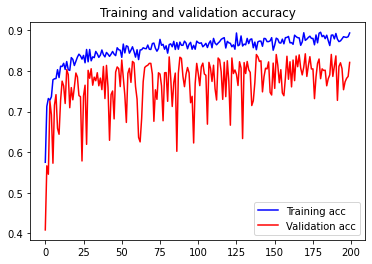

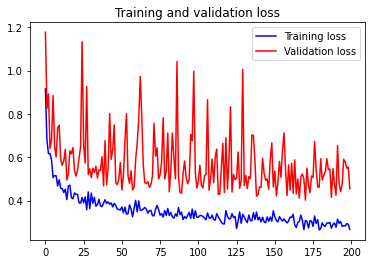

In [ ]:
visualize_results(transfer_learning_history5)
# current date and time
now = datetime.datetime.now()
timestamp = datetime.datetime.timestamp(now)
mod_model5.save('implant_modified_vgg16_model5_tl.' + str(timestamp) + '.h5')

In [ ]:
# evaluate the performance the new model and report the results
score5 = mod_model5.evaluate_generator(val_dataset, nb_validate_samples/batch_size)
print("Test Score:", score5[0])
print("Test Accuracy:", score5[1])

Test Score: 0.409423235309335
Test Accuracy: 0.8407079582720731


#MODEL 5 notes


Training time: 5:51:28.545880

Test Score: 0.4409982794154007

Test Accuracy: 0.8371681349467387

Test Score: 0.409423235309335

Test Accuracy: 0.8407079582720731



Epoch 200/200
165/165 [==============================] - 103s 622ms/step - loss: 0.2678 - acc: 0.8933 - val_loss: 0.4544 - val_acc: 0.8209

# Visualisation all models


In [ ]:
#loop all saved model and visualize them
for i in histories:
  print(i.model)
  visualize_results(i)

# Predict the new images with different models

The prediction result is putting in different file in same folder - ***Using4Model-VGG16.ipynb***



##Notes for the experiment result with
### 1. Optimizer: sgd, adam, rmsprop
### sgd not good, 50 epochs but not change much 
### adam : good from 47% to 86% but not stable. For the long run, 200 epoch, 92% acc
### rmsprop: from 48% to 81%, not good as adam

### 2. activation functions: 'relu' ..

### 3. Augmentation methods

### 4. Enable/disable some layers

### 5. Run from scratch instead of transfer learning

